In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn
import warnings
import joblib
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor


## Data Preperation

In [2]:
df = pd.read_csv('Datasets/augmented_SRQ_data_v2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12560 entries, 0 to 12559
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           12560 non-null  int64 
 1   Date                 12560 non-null  object
 2   Flight               12560 non-null  object
 3   Destination Airport  12560 non-null  object
 4   Airline              12560 non-null  object
 5   Boarded              12560 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 588.9+ KB


In [3]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

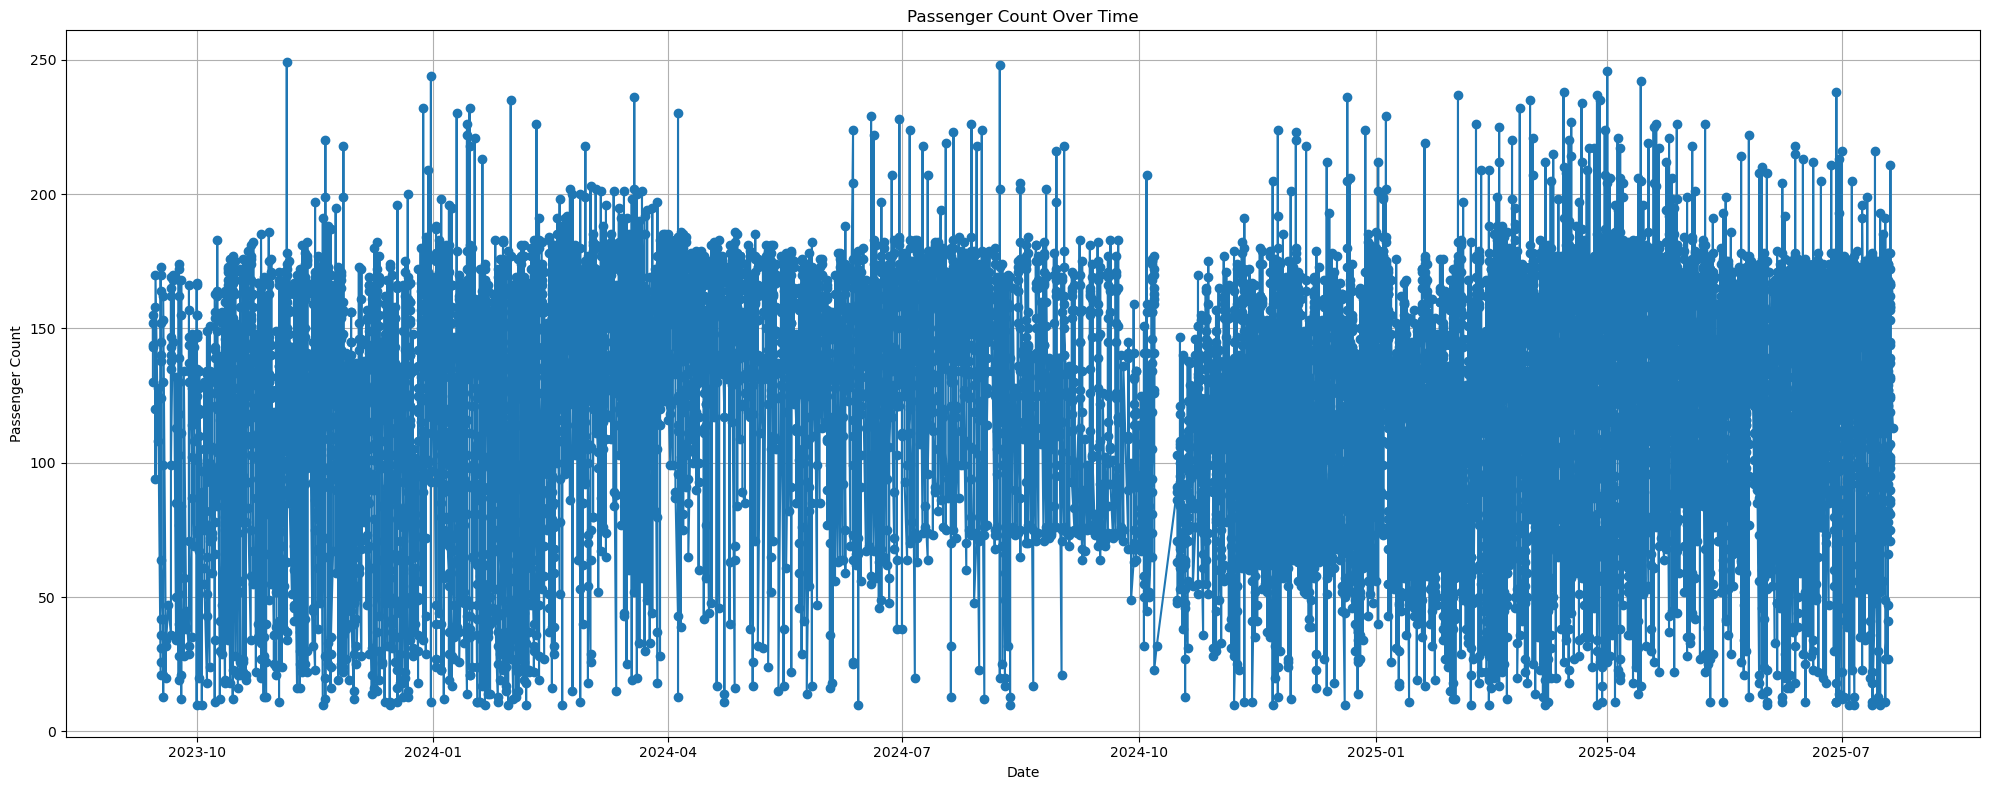

In [4]:
plt.figure(figsize=(20,8))
plt.plot(df['Date'], df['Boarded'], marker='o', linestyle='-')
plt.title('Passenger Count Over Time')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Extract time-based features
#df['Hour'] = df['Flight Time'].dt.hour
df['Day_of_Week'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['Date'].dt.month
df['Day_of_Month'] = df['Date'].dt.day

# Create time-based categories
#df['Time_Category'] = pd.cut(df['Hour'], 
                           #bins=[0, 6, 12, 18, 24], 
                           #labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Encode categorical variables
label_encoders = {}
categorical_columns = ['Destination Airport', 'Airline']

for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

df

,Unnamed: 0,Date,Flight,Destination Airport,Airline,Boarded,Day_of_Week,Month,Day_of_Month,Destination Airport_encoded,Airline_encoded
0,0,2023-09-14,AA2679,DFW,AA,130,3,9,14,23,0
1,2,2023-09-14,G41150,PIT,G4,155,3,9,14,60,5
2,3,2023-09-14,G4183,ABE,G4,152,3,9,14,0,5
3,4,2023-09-14,G4218,AVL,G4,144,3,9,14,6,5
4,5,2023-09-14,G42977,CAK,G4,143,3,9,14,14,5
...,...,...,...,...,...,...,...,...,...,...,...
12555,13273,2025-07-20,WN4409,IND,WN,71,6,7,20,40,9
12556,13274,2025-07-20,WN4605,MDW,WN,125,6,7,20,49,9
12557,13275,2025-07-20,WN4606,STL,WN,75,6,7,20,71,9
12558,13276,2025-07-20,XP306,HVN,XP,132,6,7,20,36,10


In [6]:
df['day_sin'] = np.sin(2*np.pi*df['Day_of_Month']/31)
df['day_cos'] = np.cos(2*np.pi*df['Day_of_Month']/31)

# Month (1–12) → convert to 0–11 by subtracting 1, then encode
df['month_sin'] = np.sin(2 * np.pi * (df['Month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['Month'] - 1) / 12)

# Day of Week → if 0=Monday…6=Sunday, just divide by 7
df['dow_sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12560 entries, 0 to 12559
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Unnamed: 0                   12560 non-null  int64         
 1   Date                         12560 non-null  datetime64[ns]
 2   Flight                       12560 non-null  object        
 3   Destination Airport          12560 non-null  object        
 4   Airline                      12560 non-null  object        
 5   Boarded                      12560 non-null  int64         
 6   Day_of_Week                  12560 non-null  int32         
 7   Month                        12560 non-null  int32         
 8   Day_of_Month                 12560 non-null  int32         
 9   Destination Airport_encoded  12560 non-null  int32         
 10  Airline_encoded              12560 non-null  int32         
 11  day_sin                      12560 non-nu

In [7]:
route_stats = df.groupby(['Airline','Destination Airport'])['Boarded'].agg([
    ('route_mean','mean'),
    ('route_median','median'),
    ('route_std','std'),
]).reset_index()
df = df.merge(route_stats, on=['Airline','Destination Airport'], how='left')
df

,Unnamed: 0,Date,Flight,Destination Airport,Airline,Boarded,Day_of_Week,Month,Day_of_Month,Destination Airport_encoded,Airline_encoded,day_sin,day_cos,month_sin,month_cos,dow_sin,dow_cos,route_mean,route_median,route_std
0,0,2023-09-14,AA2679,DFW,AA,130,3,9,14,23,0,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,96.518750,99.5,51.749150
1,2,2023-09-14,G41150,PIT,G4,155,3,9,14,60,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,148.430034,162.0,34.409989
2,3,2023-09-14,G4183,ABE,G4,152,3,9,14,0,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,150.730769,157.0,23.763546
3,4,2023-09-14,G4218,AVL,G4,144,3,9,14,6,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,126.549550,133.5,33.820457
4,5,2023-09-14,G42977,CAK,G4,143,3,9,14,14,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,152.762452,160.0,22.801929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12555,13273,2025-07-20,WN4409,IND,WN,71,6,7,20,40,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,105.357143,111.0,35.060103
12556,13274,2025-07-20,WN4605,MDW,WN,125,6,7,20,49,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,120.400000,122.0,39.266401
12557,13275,2025-07-20,WN4606,STL,WN,75,6,7,20,71,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,119.448980,128.0,35.404741
12558,13276,2025-07-20,XP306,HVN,XP,132,6,7,20,36,10,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,121.601604,129.0,37.176401


In [8]:
# Select features for modeling
feature_columns = [
    'Destination Airport_encoded', 'Airline_encoded',
    #'Day_of_Week', 'Month', 'Day_of_Month', 
    'day_sin',  'month_sin', 'dow_sin',
    'day_cos', 'month_cos', 'dow_cos', 
    'route_mean', 'route_median', 'route_std'
]

X = df[feature_columns]
y = df['Boarded']

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (12560, 11)
Target shape: (12560,)


In [9]:
#Need to drop time stamps for modeling but need the timestamps to present data
df_timestamps = df['Date']

split_factor = 0.8
split_index = int(len(df) * split_factor)

train_df = df[:split_index]
test_df = df[split_index:]

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=None
# )

# Extract X and y from train and test sets
X_train = train_df[feature_columns]
y_train = train_df['Boarded']

X_test = test_df[feature_columns]
y_test = test_df['Boarded']


print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training target range: {y_train.min()} to {y_train.max()}")
print(f"Testing target range: {y_test.min()} to {y_test.max()}")

Training set size: 10048
Testing set size: 2512
Training target range: 10 to 249
Testing target range: 10 to 238


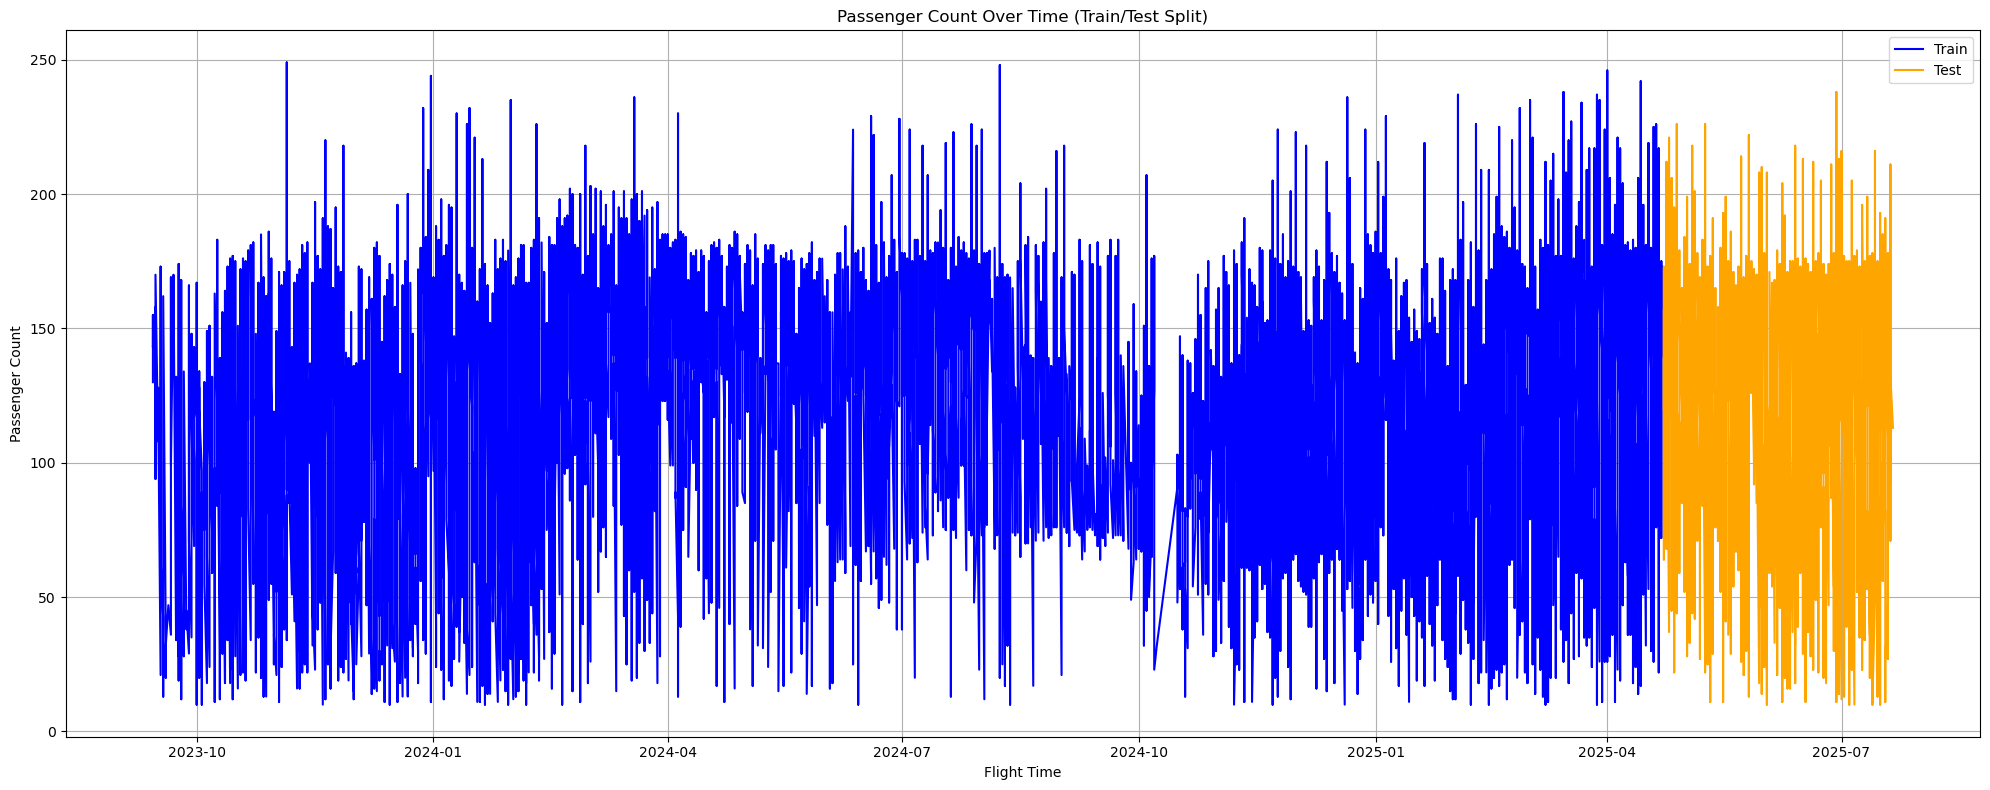

In [10]:
plt.figure(figsize=(20,8))

plt.plot(df_timestamps[:split_index], y_train, label='Train', color='blue')
plt.plot(df_timestamps[split_index:], y_test, label='Test', color='orange')

plt.title('Passenger Count Over Time (Train/Test Split)')
plt.xlabel('Flight Time')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## XGBoost

In [11]:
tscv= TimeSeriesSplit(3)

In [12]:
# arameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}

# xgb_grid = GridSearchCV(xgb1,
#                         parameters,
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)

In [13]:
param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.1, 0.01, .03, .07], #so called `eta` value [.03, 0.05, .07]
              'max_depth': [4, 5, 6,],
              'min_child_weight': [4],
              'verbosity': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [600]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=tscv)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

In [14]:
# Training the XGBoost model

from xgboost import XGBRegressor

xgb_model = XGBRegressor(**best_params)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=4, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, nthread=4, ...)

In [15]:
# Evaluating the XGBoost model on the testing set square based loss function

predictions = xgb_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Model Performance on Test Set:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")
#print(f"Out-of-Bag Score: {best_rf.oob_score_:.4f}")

# Context for interpretation
print(f"\nFor context:")
print(f"Average passenger count: {y_test.mean():.1f}")
print(f"Typical prediction error: ±{rmse:.1f} passengers")

Model Performance on Test Set:
Mean Squared Error: 891.1837
Root Mean Squared Error: 29.8527
Mean Absolute Error: 22.3806
R-squared Score: 0.4011

For context:
Average passenger count: 126.8
Typical prediction error: ±29.9 passengers


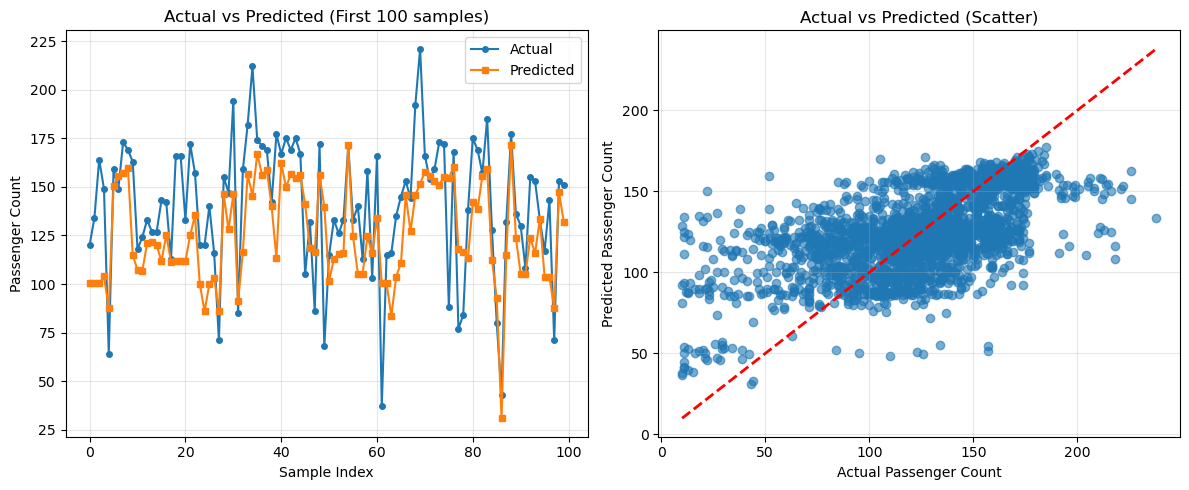

In [16]:
# Plot actual vs predicted
plt.figure(figsize=(12, 5))

# Line plot
plt.subplot(1, 2, 1)
plt.plot(y_test.values[:100], label='Actual', marker='o', markersize=4)
plt.plot(predictions[:100], label='Predicted', marker='s', markersize=4)
plt.title('Actual vs Predicted (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.title('Actual vs Predicted (Scatter)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Feature Importance:
                        feature  importance
9                  route_median    0.315490
8                    route_mean    0.282455
1               Airline_encoded    0.126445
3                     month_sin    0.073914
7                       dow_cos    0.048614
6                     month_cos    0.043051
10                    route_std    0.029350
2                       day_sin    0.024411
4                       dow_sin    0.019679
5                       day_cos    0.018775
0   Destination Airport_encoded    0.017818


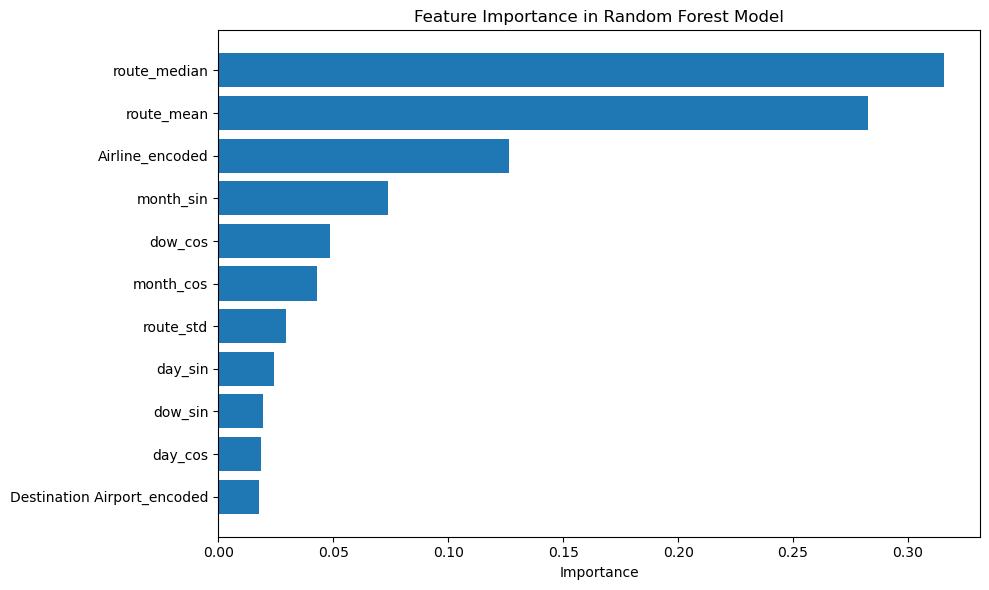

In [17]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()